In [4]:
import os
import pandas as pd
from data_process import dti_process

def files():
    folder = "park4\\NITRC_PD_DATA"
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    rows = []
    for i in subfolders:
        files = [ os.path.join(i,file) for file in os.listdir(i) if "1000" in file]
        rows.append(files)
    return rows

def pd_group(string):
    if string == "Control":
        return 0
    return 1

def processed_data():
    csv = pd.read_csv("PDClinicalData.csv")
    rows = files()
    # print(rows)
    data = []
    for i in rows:
        row = i[0].split("\\")[-2]
        i.append(pd_group(csv.loc[csv['Subject'] == row]['Group'].to_list()[0]))
        i.append(csv.loc[csv['Subject'] == row]['HADS_depression'].to_list()[0])
        data.append(i)
        # print(i)
    return data

def calculate_dtic():
    data = processed_data()
    final_data = []
    for row in data:
        nii_file,bval_file,bvec_file = row[0],row[1],row[2]
        fa,md,rd,ad = dti_process(nii_file,bval_file,bvec_file)
        pd_status, depression = row[3],row[4]
        final_row = [[fa,md,rd,ad],[pd_status,depression]]
        final_data.append(final_row)
    return final_data

In [5]:
from unicodedata import name
import sklearn
import random
from sklearn.model_selection import train_test_split
from load_data import *
import numpy as np

# def shuffle(data):
#     random.shuffle(data)

def split(data):
    random.shuffle(data)
    x = [i[0] for i in data]
    y = [i[1] for i in data]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
    x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5)
    print(len(x_train),len(x_test),len(x_val))

def fa_only(data):
    fa_data = []
    for i in data:
        fa_data.append([i[0][0],i[1]])
    return fa_data

def flatten(data):
    flattened_data = []
    for i in data:
        fa = np.array(i[0][0]).flatten()
        md = np.array(i[0][1]).flatten()
        rd = np.array(i[0][2]).flatten()
        ad = np.array(i[0][3]).flatten()
        flattened_data.append([[fa,md,rd,ad],i[1]])
    return flattened_data

def pd_only(data):
    pd_data = []
    for i in data:
        pd_data.append([i[0],i[1][0]])
    return pd_data

def depression_only(data):
    dep_thresh = 4
    depression_data = []
    for i in data:
        if i[1][0]>dep_thresh:
            depression_data.append([i[0],1])
        else:
            depression_data.append([i[0],0])
    return depression_data

# if __name__ == '__main__':
#     data = calculate_dtic()
#     flat_data = flatten(data)
#     fa_data = fa_only(flat_data)
#     pd_out_data = pd_only(fa_data)
#     split(pd_out_data)
#     np.save("pd_out_data.npy",np.array(pd_out_data, dtype=object))

In [6]:
data = calculate_dtic()

data

[[[array([[[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]],
   
          ...,
   
          [[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 

In [22]:
import pickle

with open("dataDump.txt", 'wb') as dumpFile:
    pickle.dump(data, dumpFile)

In [23]:
with open('dataDump.txt', 'rb') as dumpFile:
    data = pickle.load(dumpFile)

(63, 67, 54)

In [14]:
from scipy.ndimage import zoom
from tqdm import tqdm

minimumDimension = 100000
for x in data:
    for y in range(4):
        minimumDimension = min(min(x[0][y].shape), minimumDimension)

for x in tqdm(data):
    for y in range(4):
        x[0][y] = zoom(x[0][y], (50/x[0][y].shape[0], 50/x[0][y].shape[1], 50/x[0][y].shape[2]))

100%|██████████| 53/53 [00:09<00:00,  5.59it/s]


In [59]:
x_data = []
y_data = []

for x in data:
    x_data.append(np.moveaxis(np.array(x[0]), 0, -1))
    y_data.append(x[1][1])

y_data = [1 if x >= 8 else 0 for x in y_data]

x_data[0].shape

(50, 50, 50, 4)

In [81]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(x_data))

X_train, X_test, y_train, y_test, indices_train, indices_test = [np.array(x) for x in train_test_split(np.array(x_data), np.array(y_data), indices, test_size=0.2, random_state=42)]

In [83]:
indices_test

array([19, 41, 47, 12, 43,  5, 17, 50,  3, 32, 13])

In [103]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

model = Sequential()
model.add(Conv3D(4, kernel_size=(3, 3, 3), activation='relu', input_shape=(50, 50, 50, 4), padding='same'))
model.add(Conv3D(4, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))
model.add(Conv3D(4, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))
model.add(Conv3D(4, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(Conv3D(4, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))
model.add(Conv3D(4, kernel_size=(3, 3, 3), activation='sigmoid', padding='same'))
model.add(Flatten())
model.add(Dense(256, activation='softmax'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.05),
              metrics=['accuracy'])
model.summary()
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=10,
            epochs=25,
            verbose=1)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_66 (Conv3D)           (None, 50, 50, 50, 4)     436       
_________________________________________________________________
conv3d_67 (Conv3D)           (None, 50, 50, 50, 4)     436       
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 50, 50, 50, 4)     436       
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 50, 50, 50, 4)     436       
_________________________________________________________________
conv3d_70 (Conv3D)           (None, 50, 50, 50, 4)     436       
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 50, 50, 50, 4)     436       
_________________________________________________________________
flatten_26 (Flatten)         (None, 500000)          

In [104]:
model.save('cnnBrain2')

INFO:tensorflow:Assets written to: cnnBrain2\assets


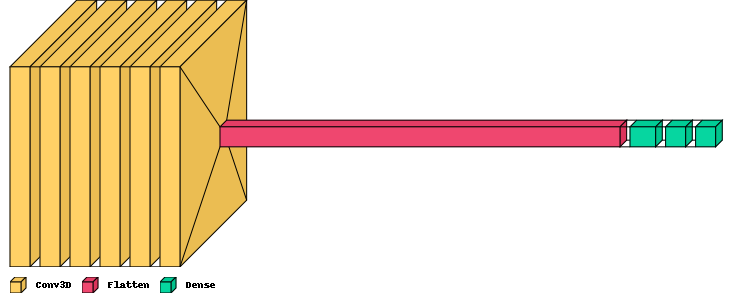

In [105]:
import visualkeras
visualkeras.layered_view(model, legend=True) 

In [114]:
pred = model.predict(X_train)
pred = np.argmax(pred)

label = np.argmax(y_train)

print(pred) 
print(label)

0
3


In [110]:
model.evaluate(X_train, y_train, verbose=True)

2/2 [==============================] - 4s 929ms/step - loss: 0.3672 - accuracy: 0.8810


[0.36716753244400024, 0.8809523582458496]

In [87]:
for layer in model.layers:
    if 'conv' in layer.name:
        weights, bias= layer.get_weights()
        print(layer.name)
        
        #normalize filter values between  0 and 1 for visualization
        f_min, f_max = weights.min(), weights.max()
        filters = (weights - f_min) / (f_max - f_min)  
        print(filters.shape)
        filter_cnt=1
        

conv3d_44
(3, 3, 3, 4, 8)
conv3d_45
(3, 3, 3, 8, 8)
conv3d_46
(3, 3, 3, 8, 8)
conv3d_47
(3, 3, 3, 8, 8)


In [74]:
feature_maps = model.predict(X_test)

In [88]:
import tensorflow as tf

successive_outputs = [layer.output for layer in model.layers]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
print(X_test.shape)
successive_feature_maps = visualization_model.predict(X_test)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
    print(layer_name, feature_map.shape)

(11, 50, 50, 50, 4)
conv3d_44 (11, 48, 48, 48, 8)
conv3d_45 (11, 46, 46, 46, 8)
max_pooling3d_44 (11, 23, 23, 23, 8)
batch_normalization_44 (11, 23, 23, 23, 8)
conv3d_46 (11, 21, 21, 21, 8)
conv3d_47 (11, 19, 19, 19, 8)
max_pooling3d_45 (11, 9, 9, 9, 8)
batch_normalization_45 (11, 9, 9, 9, 8)
flatten_22 (11, 5832)
dense_66 (11, 256)
dense_67 (11, 64)
dense_68 (11, 1)


In [ ]:
import nibabel as nib
import pickle
from dipy.io.image import load_nifti
import numpy as np
import os
# with open('dataDump_zoom_default.txt', 'rb') as dumpFile:
#         data = pickle.load(dumpFile)


data, affine = load_nifti("park4\\NITRC_PD_DATA\\p06316\\p06316_bmatrix_1000.nii.gz")
fa_img = nib.Nifti1Image(fa.astype(np.float32), affine)
# nib.save(fa_img, 'tensor_fa50.nii.gz')


In [99]:
patientWiseFAImages = []
niiLocation = [x[0] + '\\' + x[0].split('\\')[-1] + "_bmatrix_1000.nii.gz" for x in os.walk('./park4/')][2:]
for patient, id in zip(successive_feature_maps[1], indices_test):
    newImages = np.moveaxis(patient, -1, 0)
    patientWiseFAImages.append(newImages)
    data, affine = load_nifti(niiLocation[id])
    for x in range(8):
        fa_img = nib.Nifti1Image(newImages[x].astype(np.float32), affine)
        nib.save(fa_img, f'tensor_fa50_{x}.nii.gz')
    break